In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join

In [39]:
rewards_df = pd.read_csv(join("..", "out", "experiments", "digital", "rewards.csv"))
rewards_df["trainer_intersection"].replace({
    "grid-3x3": "Grid-3x3", 
    "grid-5x5": "Grid-5x5", 
    "double": "Double"
}, inplace=True)
rewards_df["netfile"].replace({
    "grid_3x3": "Grid-3x3", 
    "grid_5x5": "Grid-5x5", 
    "double_loop": "Double"
}, inplace=True)
rewards_df.head()

,Unnamed: 0,tls_id,reward,netfile,step,n_vehicles,policy,trainer,trainer_intersection,trainer_ranked
0,0,A0,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,FedRL,Double,ranked
1,1,A1,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,FedRL,Double,ranked
2,2,A2,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,FedRL,Double,ranked
3,3,B0,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,FedRL,Double,ranked
4,4,B1,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,FedRL,Double,ranked


In [40]:
features_df = pd.read_csv(join("..", "out", "experiments", "digital", "features.csv"))
features_df["trainer_intersection"].replace({
    "grid-3x3": "Grid-3x3", 
    "grid-5x5": "Grid-5x5", 
    "double": "Double"
}, inplace=True)
features_df["netfile"].replace({
    "grid_3x3": "Grid-3x3", 
    "grid_5x5": "Grid-5x5", 
    "double_loop": "Double"
}, inplace=True)
features_df.head()

,Unnamed: 0,feature,value,netfile,tls,policy,ranked,trainer,trainer_intersection,trainer_ranked
0,0,lane_occupancy,0.0,Grid-3x3,A0,v3_pos-reward-aggr_ranked.pkl,True,FedRL,Double,ranked
1,1,lane_occupancy,0.0,Grid-3x3,A1,v3_pos-reward-aggr_ranked.pkl,True,FedRL,Double,ranked
2,2,lane_occupancy,0.0,Grid-3x3,A2,v3_pos-reward-aggr_ranked.pkl,True,FedRL,Double,ranked
3,3,lane_occupancy,0.0,Grid-3x3,B0,v3_pos-reward-aggr_ranked.pkl,True,FedRL,Double,ranked
4,4,lane_occupancy,0.0,Grid-3x3,B1,v3_pos-reward-aggr_ranked.pkl,True,FedRL,Double,ranked


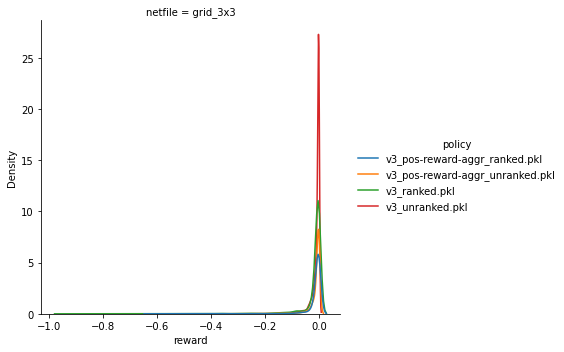

In [24]:
sns.displot(data=rewards_df, kind="kde", col="netfile", x="reward", hue="policy", facet_kws={"sharey": False, "sharex": False})
plt.show()

In [17]:
rewards_df["reward"].describe()

count    233280.000000
mean         -0.034301
std           0.113520
min          -1.777778
25%          -0.020135
50%          -0.005265
75%          -0.000842
max          -0.000000
Name: reward, dtype: float64

In [52]:
matrices = {}
for trainer in rewards_df["trainer"].unique():
    for ranked in ["ranked", "unranked"]:
        matrix = []
        for trained_on in ['Grid-3x3', 'Grid-5x5', 'Double']:
            row = []
            for evaled_on in ['Grid-3x3', 'Grid-5x5', 'Double']:
                q = f"trainer == '{trainer}' and trainer_ranked == '{ranked}' and " \
                    f"trainer_intersection == '{trained_on}' and netfile == '{evaled_on}'"
                query = rewards_df.query(q)
                row.append(query["reward"].mean())
            matrix.append(row)
        matrices[trainer, ranked] = np.array(matrix)

matrices.keys()

dict_keys([('FedRL', 'ranked'), ('FedRL', 'unranked'), ('MARL', 'ranked'), ('MARL', 'unranked'), ('SARL', 'ranked'), ('SARL', 'unranked')])

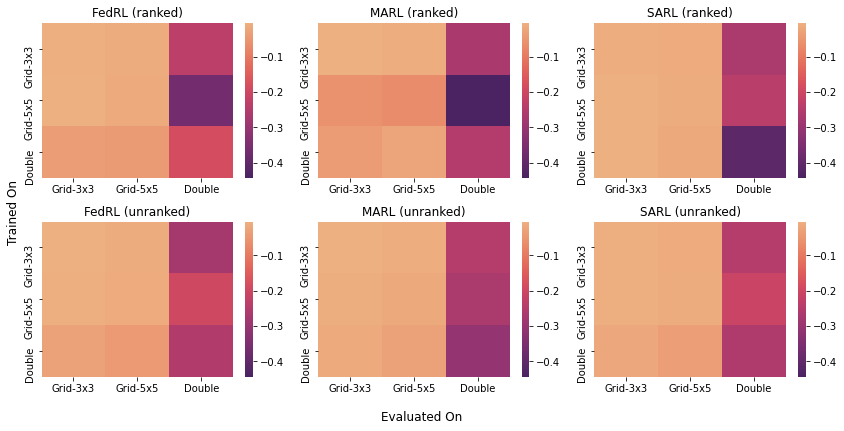

In [60]:
RANKS = ["ranked", "unranked"]
TRAINERS = ["FedRL", "MARL", "SARL"]

vmin, vmax = float("inf"), float("-inf")
for matrix in matrices.values():
    mat = matrix.flatten()
    vmin = min(vmin, mat.min())
    vmax = max(vmax, mat.max())
    
fig, axes = plt.subplots(nrows=len(RANKS), ncols=len(TRAINERS), figsize=(12, 6))

for row, ranked in enumerate(RANKS):
    for col, trainer in enumerate(TRAINERS):
        f = sns.heatmap(
            matrices[trainer, ranked],
            xticklabels=['Grid-3x3', 'Grid-5x5', 'Double'],
            yticklabels=['Grid-3x3', 'Grid-5x5', 'Double'],
            vmin=vmin,
            vmax=vmax,
            cmap="flare_r",
            ax=axes[row, col]
        )
        axes[row, col].set_title(f"{trainer} ({ranked})")

fig.supylabel("Trained On")
fig.supxlabel("Evaluated On")
plt.tight_layout()
plt.show()

In [41]:
rewards_df["trainer_intersection"].unique()

array(['Double', 'Grid-3x3', 'Grid-5x5'], dtype=object)

In [42]:
rewards_df["netfile"].unique()

array(['Grid-3x3', 'Grid-5x5', 'Double'], dtype=object)

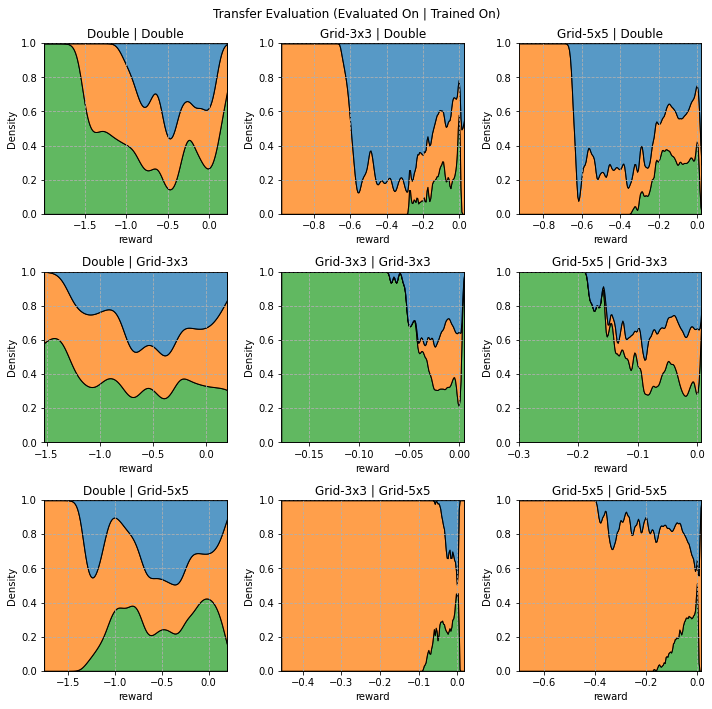

In [98]:
netfiles = ["Double", "Grid-3x3", "Grid-5x5"]

fig, ax = plt.subplots(nrows=len(netfiles), ncols=len(netfiles), figsize=(10, 10))
for row, trained_on in enumerate(netfiles):
    for col, eval_on in enumerate(netfiles):
        q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}'"
        sns.kdeplot(
            data=rewards_df.query(q), 
            x="reward", 
            hue="trainer", 
            ax=ax[row, col],
            multiple="fill",
            legend=False,
        )#.set(yscale="log")
        ax[row, col].set_title(f"{eval_on} | {trained_on}")
        ax[row, col].grid(which="major", linestyle="--")
        # handles, labels = axes[row, col].get_legend_handles_labels()
        # axes[row, col].get_legend().remove()
        
# fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.05))
plt.suptitle("Transfer Evaluation (Evaluated On | Trained On)")
plt.tight_layout()
plt.show()